# Define Synthetic Dataset Blob

Track A (synthetic drift): Gaussian mixtures
	Define 3 drift bins: low / medium / high (by Wasserstein distance)
	Include a revisit test (return to T1)
Track B (vision drift):
	MNIST → MNIST‑M baseline shift
	Plan SVHN subset next step
	Keep pooled control run (multi-domain)

In [15]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import torch

## Track A - Gaussina mixtures

In [17]:
from sklearn.datasets import make_blobs
scaler = sklearn.preprocessing.StandardScaler()
n_samples = 1500
np.random.seed(42)
torch.manual_seed(42)
transformation = [[0.6, -0.2], [-0.4, 0.7]]

In [18]:
X_ls = []
X1, y = make_blobs(n_samples=n_samples, random_state=42, centers=4)
X_ls.append(scaler.fit_transform(X1))
X_ls.append(scaler.fit_transform(np.dot(X1, transformation)))  # Anisotropic blobs
X2, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2., 0.8, .5], random_state=43, centers=4
)  # Unequal variance
X_ls.append( scaler.fit_transform((X2)))
X1, y = make_blobs(n_samples=n_samples, random_state=40, centers=4, cluster_std=[.5, 1.3, 0.5, 1.3])
X_filtered = np.vstack(
    (X1[y == 0][:100], X1[y == 1][:500], X1[y == 2][:100], X1[y == 3][:500])
)  # Unevenly sized blobs
X_ls.append(scaler.fit_transform(X_filtered))


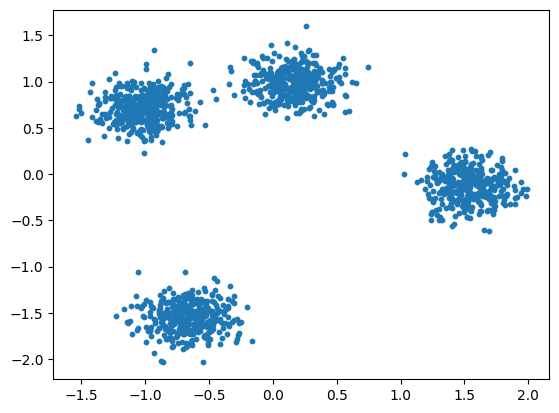

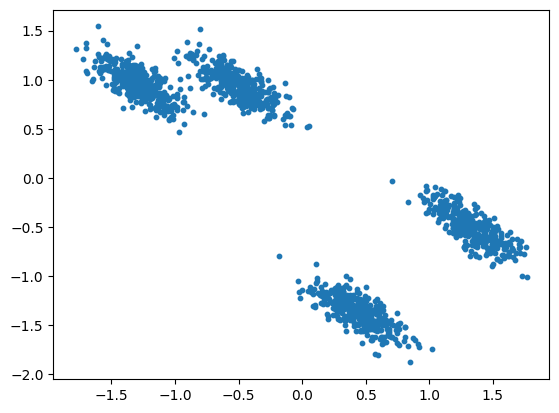

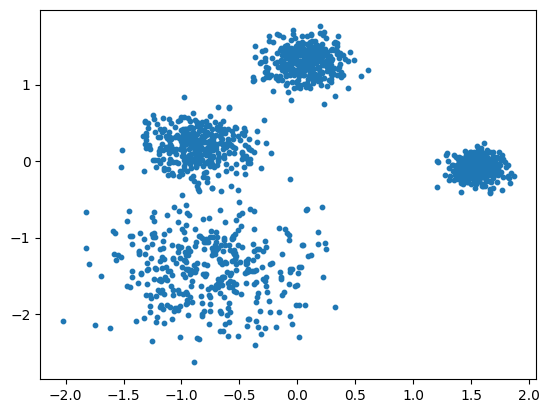

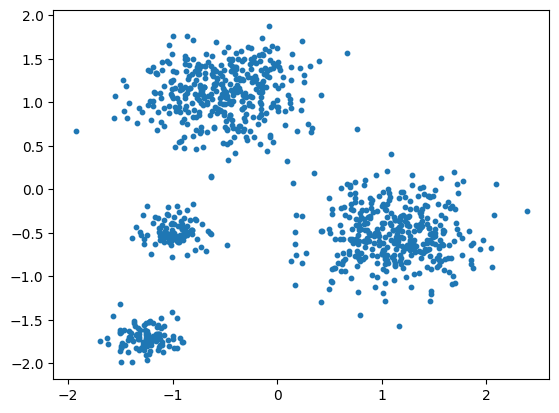

In [24]:
for X in X_ls:
    plt.scatter(X[:,0],X[:,1], s=10)
    plt.show()

In [40]:
# pip install numpy scikit-learn pot matplotlib
from dataclasses import dataclass
import numpy as np, ot
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

@dataclass
class DriftConfig:
    d: int = 2; K: int = 3; n_per: int = 400; std_base: float = 0.7
    mode: str = "new_component"    # "new_component" or "directional_shift"
    w2_incl: float = 0.05; w3_incl: float = 0.25
    incl_std: float = 0.9; incl_dist: float = 5.0
    thr_low: float = 0.8; thr_med: float = 1.6
    seed: int = 17


In [41]:
# Basic 3 Blobs
def gen_base(cfg, centers=None, n_total=None, seed=None):
    rng = np.random.RandomState(cfg.seed if seed is None else seed)
    C = rng.uniform(-6, 6, size=(cfg.K, cfg.d)) if centers is None else centers
    N = cfg.K*cfg.n_per if n_total is None else n_total
    per = [N//cfg.K]*cfg.K
    per[-1] += N-sum(per)
    Xs, ys = [], []
    for k, nk in enumerate(per):
        if nk<=0: continue
        Xk, yk = make_blobs(n_samples=nk, centers=C[k].reshape(1,-1),
                            cluster_std=cfg.std_base, n_features=cfg.d,
                            random_state=(cfg.seed if seed is None else seed)+10+k)
        yk[:] = k
        Xs.append(Xk); ys.append(yk)
    return (np.vstack(Xs), np.concatenate(ys), C) if Xs else (np.empty((0,cfg.d)), np.empty((0,),int), C)

In [ ]:
def gen_new_component(cfg, centers, n_new, seed=None):
    if n_new<=0: return np.empty((0,cfg.d)), np.empty((0,),int)
    rng = np.random.RandomState(cfg.seed if seed is None else seed)
    u = rng.normal(size=cfg.d)
    u/= (np.linalg.norm(u)+1e-12)
    ctr = centers.mean(0) + u*cfg.incl_dist
    X, y = make_blobs(n_samples=n_new, centers=ctr.reshape(1,-1),
                      cluster_std=cfg.incl_std, n_features=cfg.d,
                      random_state=(cfg.seed if seed is None else seed)+100)
    y[:] = centers.shape[0]
    return X, y

def gen_directional_shift(cfg, Xb, yb, n_new, seed=None):
    if n_new<=0: return np.empty((0,Xb.shape[1])), np.empty((0,),int)
    rng = np.random.RandomState(cfg.seed if seed is None else seed)
    u = rng.normal(size=Xb.shape[1]); u/= (np.linalg.norm(u)+1e-12)
    shift = u*cfg.incl_dist
    idx = rng.choice(Xb.shape[0]-1, size=n_new, replace=True)
    X = Xb[idx] + shift + rng.normal(scale=0.25, size=(n_new, Xb.shape[1]))
    return X, yb[idx]

def w2_distance(X1, X2):
    sc = StandardScaler().fit(X1)
    Xr, Xc = sc.transform(X1), sc.transform(X2)
    n = Xr.shape[0]; a = np.ones(n)/n; b = np.ones(n)/n
    M = ot.dist(Xr, Xc)**2
    return np.sqrt((ot.emd(a, b, M)*M).sum())

def run(cfg: DriftConfig):
    ; 

    
    X3, y3 = np.vstack([X3b, X3n]), np.concatenate([y3b, y3n])
    X4, y4, _ = gen_base(cfg, centers=C, n_total=N, seed=cfg.seed+5)
    w12, w13, w14 = w2_distance(X1, X2), w2_distance(X1, X3), w2_distance(X1, X4)
    binf = lambda w: "low" if w<cfg.thr_low else ("medium" if w<cfg.thr_med else "high")
    print(f"T1 vs T2: {w12:.3f} -> {binf(w12)}")
    print(f"T1 vs T3: {w13:.3f} -> {binf(w13)}")
    print(f"T1 vs T4: {w14:.3f} -> {binf(w14)}")
    return (X1,y1),(X2,y2),(X3,y3),(X4,y4),C

In [51]:
scatter = lambda X : plt.scatter(X[:,0], X[:,1], s=10)

In [45]:
cfg = DriftConfig(
        mode="directional_shift",   # or "new_component"
        w2_incl=0.05, w3_incl=0.25,
        incl_dist=5.0, incl_std=0.9,
        thr_low=0.8, thr_med=1.6, seed=17
    )


In [56]:
X1, y1, C = gen_base(cfg)
N = X1.shape[0]

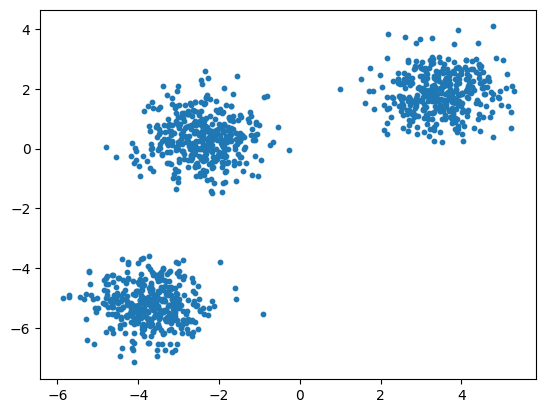

In [57]:
scatter(X1)

In [ ]:
split_count = lambda n, w: (n-round(w*n), round(w*n))

In [80]:
n2b, inc2 = split_count(N, cfg.w2_incl)
X2b, y2b, _ = gen_base(cfg, centers=C, n_total=n2b, seed=cfg.seed+1)
X2n, y2n = gen_new_component(cfg, C, inc2, seed=cfg.seed+2) # cfg.mode=="new_component"
X2, y2 = np.vstack([X2b, X2n]), np.concatenate([y2b, y2n])

In [81]:
n3b, inc3 = split_count(N, cfg.w3_incl)
X3b, y3b, _ = gen_base(cfg, centers=C, n_total=n3b, seed=cfg.seed+2)
X3n, y3n = gen_directional_shift(cfg, X3b, y3b, inc3, seed=cfg.seed+4)

IndexError: index 900 is out of bounds for axis 0 with size 900

In [ ]:

    else:
        raise ValueError("mode must be 'new_component' or 'directional_shift'")

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
    

    # Optional quick plot
    try:
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1,4,figsize=(14,3.5),sharex=True,sharey=True)
        for ax,X,t in zip(axs,[X1,X2,X3,X4],["T1","T2","T3","T4 (revisit)"]):
            ax.scatter(X[:,0],X[:,1],s=6,alpha=0.6); ax.set_title(t)
        plt.tight_layout(); plt.show()
    except Exception:
        pass